ETL

In [57]:
#Librerias
import pandas as pd
from INEGIpy import Indicadores
from sie_banxico import SIEBanxico
import matplotlib.pyplot as plt
import yaml

Importación de API's keys

In [58]:
# Ruta relativa al yaml
ruta_archivo_yaml = "../config/config.yaml"

# Cargar configuración desde config.yaml
with open(ruta_archivo_yaml, "r") as yamlfile:
    config = yaml.safe_load(yamlfile)

# Acceder al token específico para Banxico
token_banxico = config['banxico']['token'].strip()
token_inegi = config['inegi']['token'].strip()


Extracción tipo de cambio

In [59]:
# Inicializar el cliente de la API con el token y los IDs de las series a consultar
t_cambio = SIEBanxico(token=token_banxico, id_series=['SF43718'], language='en')

# Obtiene los datos de la serie en el rango de fechas deseado
data_t_cambio = t_cambio.get_timeseries_range(init_date='2000-12-31', end_date='2024-03-18')

# Transforma los datos en un DataFrame de Pandas
df = pd.DataFrame(data_t_cambio['bmx']['series'][0]['datos'])

# Cambia el nombre de la columna 'dato' a 'peso_por_dolar'
df.rename(columns={'dato': 'peso_por_dolar'}, inplace=True)

# Convierte la columna 'fecha' al formato deseado
df['fecha'] = pd.to_datetime(df['fecha'], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')

# Muestra las primeras filas del DataFrame con las modificaciones
print(df.head())

# Guarda los datos en un archivo CSV con las modificaciones
df.to_csv("../data/raw/tipo_de_cambio.csv", index=False)


        fecha peso_por_dolar
0  2001-01-02         9.7140
1  2001-01-03         9.8340
2  2001-01-04         9.7080
3  2001-01-05         9.7546
4  2001-01-08         9.6900


Extracción tasa de interés

In [60]:
# Inicializar el cliente de la API para la tasa de interés
t_interes = SIEBanxico(token=token_banxico, id_series=['SF61745'], language='en')

# Obtiene los datos de la serie en el rango de fechas deseado para la tasa de interés
data_t_interes = t_interes.get_timeseries_range(init_date='2000-12-31', end_date='2024-03-18')

# Transforma los datos de la tasa de interés en un DataFrame de Pandas
df_t_interes = pd.DataFrame(data_t_interes['bmx']['series'][0]['datos'])

# Cambia el nombre de la columna 'dato' a 'tasa_de_interes'
df_t_interes.rename(columns={'dato': 'tasa_de_interes'}, inplace=True)

# Convierte la columna 'fecha' al formato deseado
df_t_interes['fecha'] = pd.to_datetime(df_t_interes['fecha'], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')

# Muestra las primeras filas del DataFrame de la tasa de interés
print(df_t_interes.head())

# Guarda los datos de la tasa de interés en un archivo CSV
df_t_interes.to_csv("../data/raw/tasa_de_interes.csv", index=False)


        fecha tasa_de_interes
0  2008-01-21          7.5000
1  2008-01-22          7.5000
2  2008-01-23          7.5000
3  2008-01-24          7.5000
4  2008-01-25          7.5000


Extracción del Índice e Precios y Cotizaciones (Inflación)

In [61]:
inegi = Indicadores(token_inegi)

# Reemplaza '6206972689' con el ID del indicador que deseas consultar
df_inpc = inegi.obtener_df(indicadores=['628194'], 
                      nombres=['INPC'], 
                      inicio='2000-01-01', 
                      fin='2024-02-01')

# Transforma la columna de fechas en un objeto datetime, especificando el formato
df_inpc.index = pd.to_datetime(df_inpc.index, format='%Y-%m-%d')

# Imprime las primeras y últimas filas del DataFrame para verificar
print(df_inpc.head())
print(df_inpc.tail())

df_inpc.to_csv("../data/raw/inflacion.csv", index=True, index_label='fecha')


                 INPC
fechas               
2000-01-01  44.930830
2000-02-01  45.329380
2000-03-01  45.580681
2000-04-01  45.840018
2000-05-01  46.011379
               INPC
fechas             
2023-10-01  130.609
2023-11-01  131.445
2023-12-01  132.373
2024-01-01  133.555
2024-02-01  133.681


C:\Users\antap\AppData\Roaming\Python\Python39\site-packages\INEGIpy\_indicadores.py:108: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.set_index(pd.to_datetime(df.fechas),inplace=True, drop=True)


Procesamiento de datos

In [62]:

# Leer archivos
df_tipo_cambio = pd.read_csv("../data/raw/tipo_de_cambio.csv")
df_tasa_interes = pd.read_csv("../data/raw/tasa_de_interes.csv")
df_inflacion = pd.read_csv("../data/raw/inflacion.csv")

# Buscar y eliminar duplicados
df_tipo_cambio = df_tipo_cambio.drop_duplicates()
df_tasa_interes = df_tasa_interes.drop_duplicates()
df_inflacion = df_inflacion.drop_duplicates()

# Buscar y manejar valores faltantes, por ejemplo, eliminándolos
df_tipo_cambio = df_tipo_cambio.dropna()
df_tasa_interes = df_tasa_interes.dropna()
df_inflacion = df_inflacion.dropna()

# Leer la  'fecha'y asegurarse del formato datetime
df_tipo_cambio['fecha'] = pd.to_datetime(df_tipo_cambio['fecha'])
df_tasa_interes['fecha'] = pd.to_datetime(df_tasa_interes['fecha'])
df_inflacion['fecha'] = pd.to_datetime(df_inflacion['fecha'])

# Encuentra la fecha mínima y máxima común
min_fecha = max(df_tipo_cambio['fecha'].min(), df_tasa_interes['fecha'].min(), df_inflacion['fecha'].min())
max_fecha = min(df_tipo_cambio['fecha'].max(), df_tasa_interes['fecha'].max(), df_inflacion['fecha'].max())

# Filtra cada DataFrame por el rango de fechas común
df_tipo_cambio = df_tipo_cambio[(df_tipo_cambio['fecha'] >= min_fecha) & (df_tipo_cambio['fecha'] <= max_fecha)]
df_tasa_interes = df_tasa_interes[(df_tasa_interes['fecha'] >= min_fecha) & (df_tasa_interes['fecha'] <= max_fecha)]
df_inflacion = df_inflacion[(df_inflacion['fecha'] >= min_fecha) & (df_inflacion['fecha'] <= max_fecha)]

# Guarda los DataFrames filtrados
df_tipo_cambio.to_csv("../data/processed/tipo_de_cambio.csv", index=False)
df_tasa_interes.to_csv("../data/processed/tasa_de_interes.csv", index=False)
df_inflacion.to_csv("../data/processed/inflacion.csv", index=False)



Gráficas de las series de tiempo

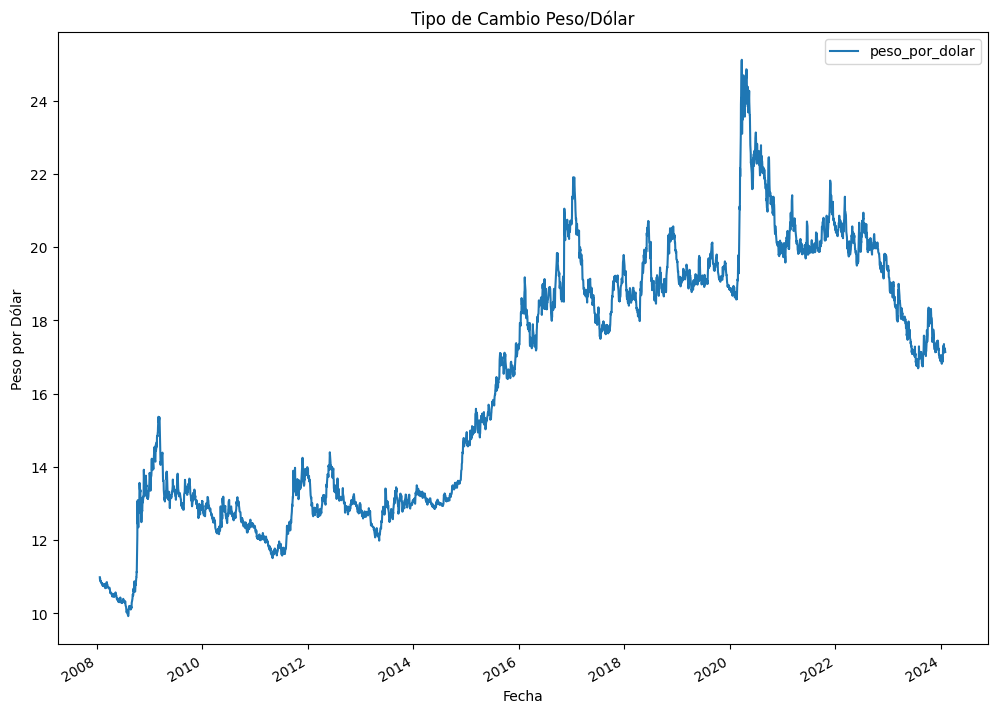

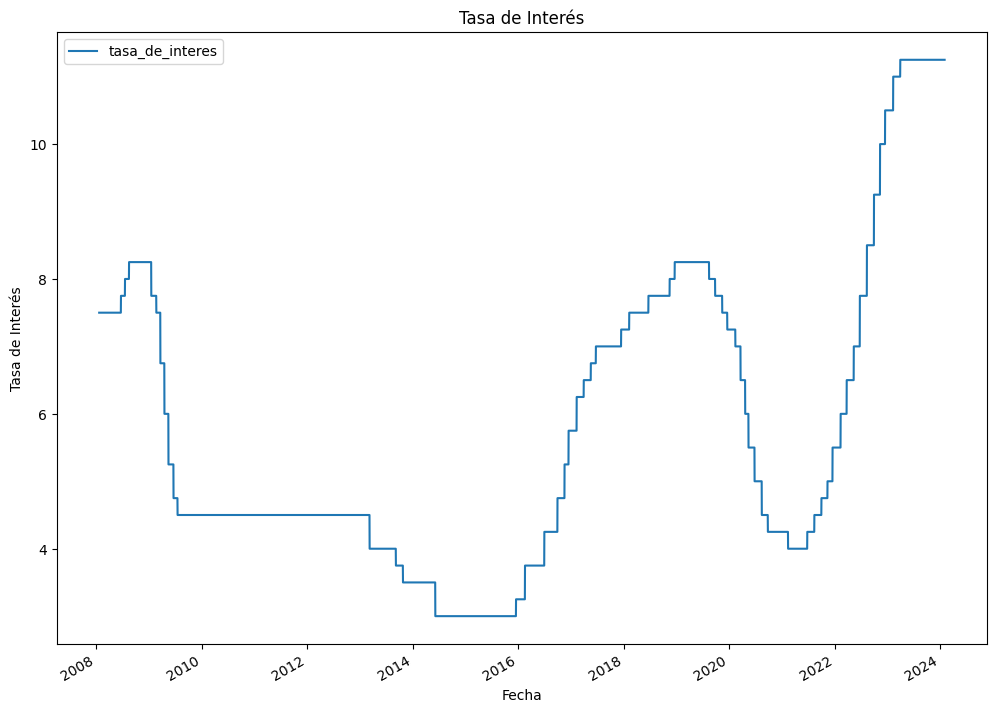

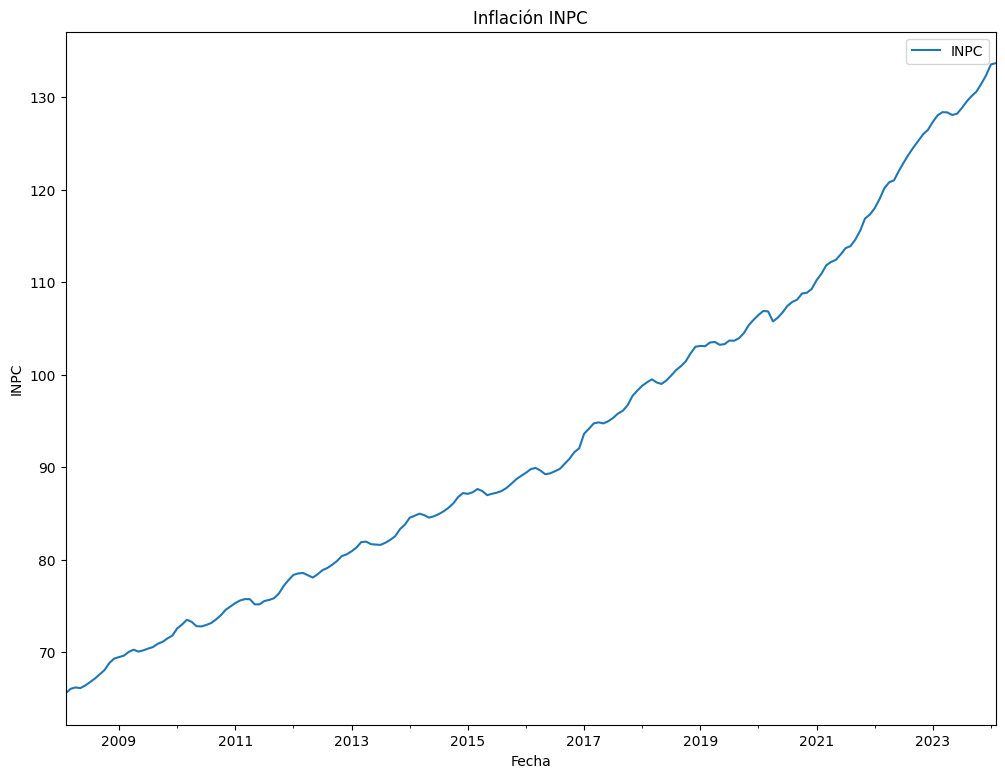

In [63]:


df_tipo_cambio.set_index('fecha', inplace=True)
df_tasa_interes.set_index('fecha', inplace=True)
df_inflacion.set_index('fecha', inplace=True)

# Gráfica tipo de cambio
df_tipo_cambio.plot(figsize=(12, 9), title='Tipo de Cambio Peso/Dólar')
plt.xlabel('Fecha')
plt.ylabel('Peso por Dólar')
plt.show()

# Gráfica tasa de interés
df_tasa_interes.plot(figsize=(12, 9), title='Tasa de Interés')
plt.xlabel('Fecha')
plt.ylabel('Tasa de Interés')
plt.show()

# Gráfica inflación (INPC)
df_inflacion.plot(figsize=(12, 9), title='Inflación INPC')
plt.xlabel('Fecha')
plt.ylabel('INPC')
plt.show()

Load

In [1]:
# Abres un cliente de S3
import boto3
session = boto3.Session(profile_name='arquitectura')
s3 = session.client('s3')

In [2]:
# Crea un nuevo Bucket
BUCKET_NAME = "itam-analytics-jantonio"
s3.create_bucket(Bucket=BUCKET_NAME)

{'ResponseMetadata': {'RequestId': 'WQVZTMSTQ4J1EKEB',
  'HostId': 'O12vhZcLmVayO3AVvMfPDd9l7C10f9Ai6TAdxGkT6E4jyzdclVZWllPKuLPpH/5j3HWqcfiMibc=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'O12vhZcLmVayO3AVvMfPDd9l7C10f9Ai6TAdxGkT6E4jyzdclVZWllPKuLPpH/5j3HWqcfiMibc=',
   'x-amz-request-id': 'WQVZTMSTQ4J1EKEB',
   'date': 'Wed, 20 Mar 2024 07:09:48 GMT',
   'location': '/itam-analytics-jantonio',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'Location': '/itam-analytics-jantonio'}

In [4]:
# Upload los dos archivos a S3
s3.upload_file(Filename="../data/processed/inflacion.csv", Bucket=BUCKET_NAME, Key="mx_econo_insights/inflacion/inflacion.csv")
s3.upload_file(Filename="../data/processed/tasa_de_interes.csv", Bucket=BUCKET_NAME, Key="mx_econo_insights/tasa_de_interes/tasa_de_interes.csv")
s3.upload_file(Filename="../data/processed/tipo_de_cambio.csv", Bucket=BUCKET_NAME, Key="mx_econo_insights/tipo_de_cambio/tipo_de_cambio.csv")